#### Quantifying NEON Precipitation Uncertainty using NOAA-GHCND

In this tutorial, we are going to demonstrate a step by step process on how to quantify [NEON](https://data.neonscience.org/data-products/DP1.00006.001) precipitation data uncertainty using [NOAA-GHCND](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00861) data. Here, you will learn how to download `NEON` precipitation data for any `NEON Station`. The NEON-Data download code block borrows from our [previous tutorial](https://cwslab.github.io/NEONDATA/index.html) which describes all the steps taken to download these data products. Please remember to check our [previous tutorial](https://cwslab.github.io/NEONDATA/index.html) for a detailed description and steps on how to download any NEON-Data product.

##### 1. Downloading NEON Data

In this demonstration, we shall access and download **TALL-NEON Precipitation data**. This code can however be applied to download any NEON station by just changing the `neon_site` name to the [location](https://www.neonscience.org/field-sites/explore-field-sites) you prefer.

**Loading the necessary packages**
<div class="alert alert-block alert-info">
<b>NOTE:</b> Remember to check our <a href="https://cwslab.github.io/NEONDATA/index.html" title=”neon_data_tutorial)”>Previous Tutorial</a> for a detailed explanation on downloading NEON datasets.</div>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging

os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
plt.rcParams.update({"font.weight": "bold", "axes.labelweight": "bold", "font.size": 10})

rpy2_logger.setLevel(logging.ERROR)
neonUtilities = importr('neonUtilities')

**Loading the necessary packages**

Using the `NEON-Utilities` package, we access and extract `TALL-NEON` precipitation data for the specified period. The `zipsbyproduct` function downloads the data while the `stackbytable` function unzips the downloaded data and consolidates it into a single file. Further details and explannation of these functions and packages can be found [here](https://cwslab.github.io/NEONDATA/index.html)

In [5]:
# Downloading precipitation data
neon_site = 'TALL'
neonUtilities.zipsByProduct(dpID='DP1.00006.001', startdate="2015-01", enddate="2023-12",
                            site=importr('base').c(neon_site), savepath='.', package='basic', 
                            timeIndex='30', check_size='TRUE')
neonUtilities.stackByTable(filepath='./filesToStack00006')

# Reading the downloaded and unzipped files
ppt_30_Minute = pd.read_csv('filesToStack00006/stackedFiles/PRIPRE_30min.csv', parse_dates=['startDateTime'])
ppt_30_Minute.set_index('startDateTime', inplace=True)

# Filter and process data
df = ppt_30_Minute.query("horizontalPosition == 900 and priPrecipFinalQF == 0")

Finding available files
  |======================================================================| 100%
Provisional data were excluded from available files list. To download provisional data, use input parameter include.provisional=TRUE.
Continuing will download files totaling approximately 45.958851 MB. Do you want to proceed y/n: y
  |======================================================================| 100%
520 files successfully downloaded to ./filesToStack00006
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
Stacking operation across a single core.
Stacking table SECPRE_30min
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                  

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~03s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~01s           |+++++                                             | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |+++++++                                           | 14% ~01s           |++++++++                                          | 15% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s           |++++++++++                                        | 18% ~00s 

##### 2. Finding NOAA GHCND Station
In this step, we are going to search for the nearest GHCND Station to our NEON Station with the most upto date data. You can modify the radius if the search yields nothing.

**Define Variables***

To request data from NOAA, we will need to request an access token, which essentially confirms that we are a trusted source asking for data: [Request a Token here](https://www.ncdc.noaa.gov/cdo-web/token).

<img src="api_token.png" width="800" height="400">

Enter your email address in the space provided to receive an email containing your access token. Remember to store this token securely and keep it private to prevent unauthorized requests to NOAA.

Once you have received your token, set your NOAA token and the coordinates of the location of interest. Here we are going to input the location for the [TALL-NEON Station](https://www.neonscience.org/field-sites/tall). 

In [6]:
token = 'hxceECtGiimzcdOTHATeUpdQVkRcszRF'
lat = 32.95047
lon = -87.393259
radius = 50  # Radius in kilometers

**Fetch and Find Data the Closest Station**

Fetch station data from the NOAA API within the defined bounding box and identify the closest GHCND station that has the most up-to-date data. The step ends by printing the details of the information of this station. If no GHCND station is found with the most recent data, you can change the radius to search for a wider area.

Here, using the location details of the `NEON` site of interest (Latitude, Longitude and Elevation), we shall search all `NOAA Stations` within a specified radius. The code extracts these stations information using the `NOAA-API`. We shall then proceed to compute the elevation using the `Open-Elevation API`. To find the closest station, we define a score based on the distance and the elevation which helps to find the NOAA station that closely matches the NEON-site according to the latitude, longitude and elevation parameters. The code then prints the station details including `station_id`, the `distance` from NEON site, `elevation difference`, `start` and `end` dates of the available data records.

**Define Functions**

* elev_by_lat_lon: Cxtracts elevation for a location given the lat, lon using the `Open Elevation API`.
* calc_dist: Calculate the distance between two points (lat and lon) using the Haversine formula (a more accurate way to computes distance between surface points given their cordinates):

In [7]:
import requests
import math
def elev_by_lat_lon(lat, lon):
    """
    Returns the elevation in meters for the specified latitude/longitude.
    Uses Open-Elevation API for this example.
    """
    url = f'https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}'
    resp = requests.get(url).json()
    if 'results' in resp and 'elevation' in resp['results'][0]:
        return resp['results'][0]['elevation']
    return None

# Get elevation for the given location
elevation = elev_by_lat_lon(lat, lon)

# Calculate distance between two points
def calc_dist(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (Volumetric mean radius) in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(
        math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

**Finding the Closest Station that Matches our NEON-Site**

In [8]:
# Fetch stations data from NOAA API
url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations'
params = {'extent': f"{lat - 0.5},{lon - 0.5},{lat + 0.5},{lon + 0.5}", 'limit': 1000}
headers = {'token': token}
response = requests.get(url, headers=headers, params=params)
stations_data = response.json()

# Find the closest GHCND station with data up to 2024 and similar elevation
min_score = float('inf')
closest_station = None

# Calculate a score based on distance and elevation difference
def calc_score(distance, elev_diff):
    return distance + abs(elev_diff) # Adjust the weighting as necessary

# Extract relevant information and find the best station
if 'results' in stations_data:
    for station in stations_data['results']:
        if station['id'].startswith('GHCND') and station.get('maxdate', '') >= '2024-01-01':
            station_lat = station['latitude']
            station_lon = station['longitude']
            station_elev = elev_by_lat_lon(station_lat, station_lon)
            
            if station_elev is not None:
                distance = calc_dist(lat, lon, station_lat, station_lon)
                elev_diff = elevation - station_elev
                score = calc_score(distance, elev_diff)
                
                if distance <= radius and score < min_score:
                    min_score = score
                    closest_station = {
                        'Station ID': station['id'],
                        'Distance': distance,
                        'Start Date': station['mindate'],
                        'End Date': station['maxdate'],
                        'Elevation Difference': elev_diff
                    }

# Display the closest station information
if closest_station:
    print(f"Closest Station ID: {closest_station['Station ID']}")
    print(f"Distance: {closest_station['Distance']:.2f} km")
    print(f"Start Date: {closest_station['Start Date']}")
    print(f"End Date: {closest_station['End Date']}")
    print(f"Elevation Difference: {closest_station['Elevation Difference']:.2f} m")
else:
    print("No GHCND station with data up to 2024 found within the specified radius.")

Closest Station ID: GHCND:USC00018809
Distance: 31.12 km
Start Date: 1940-01-01
End Date: 2024-05-24
Elevation Difference: 14.00 m


##### 3. Downloading NOAA Data

Once we obtain the closest station with the most up-to-date data records, the next step is to download the data.We define a date range where want to extract data for example, in this case, we shall create a lopp that iterates over each year from 2015 to 2023. According to the code below:

1. `requests`: Used to make HTTP requests to the NOAA API.
2. `station_id`: Stores the ID of the weather station you want to download data from.
3. `dates_prcp` and `prcp`: Initialize empty lists to store dates and precipitation data.

The code then iterate Over Years: The loop goes through each year for the defined period (our case from 2015 to 2023 and prints the progress by printing the current year being processed. In the code, we:

**Define API URL and Parameters:**

- `url`: The endpoint for the NOAA API.
- **`params`:** A dictionary containing parameters for the API request:

     - `datasetid`: Specifies the dataset (GHCND for Global Historical Climatology Network Daily).
     -  `datatypeid`: Specifies the data type (PRCP for precipitation).
     - `stationid`: Specifies the station ID.
     - `startdate` and `enddate`: Define the date range for the year.
     - `limit`: Limits the number of results (set to 1000).
     - `units`: Specifies the units (metric).

**Define Headers:** Includes the `token` for authenticating with the `NOAA API`.

**Note:** Retries are set to 3 to ensure the `API request` has multiple chances to succeed in case of temporary issues. The `try block` attempts the `API request`, checks its success, and parses the `JSON response`. If the response contains `results`, it appends the `date` and `precipitation` values to the lists; otherwise, it indicates no data. If exceptions occur, such as `RequestException` or `ValueError`, it prints an `error` message and retries after a `5-second delay`. If all retry attempts fail, it prints a failure message for that year.

In [9]:
import requests
import pandas as pd
from datetime import datetime
import time

station_id = 'GHCND:USC00018809' #The station ID obtained in the previous step
dates_prcp, prcp = [], []

for year in range(2015, 2024):
    print(f'Working on year {year}')
    url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    params = {
        'datasetid': 'GHCND', 'datatypeid': 'PRCP', 'stationid': station_id,
        'startdate': f'{year}-01-01', 'enddate': f'{year}-12-31',
        'limit': 1000, 'units': 'metric'
    }
    headers = {'token': token}
    
    retries = 3
    for _ in range(retries):
        try:
            r = requests.get(url, params=params, headers=headers)
            r.raise_for_status()
            d = r.json()
            if 'results' in d:
                dates_prcp += [item['date'] for item in d['results'] if item['datatype'] == 'PRCP']
                prcp += [item['value'] for item in d['results'] if item['datatype'] == 'PRCP']
            else:
                print(f"No data found for year {year}")
            break
        except (requests.exceptions.RequestException, ValueError) as e:
            print(f"Error: {e}. Retrying...")
            time.sleep(5)
    else:
        print(f"Failed to retrieve data for year {year} after {retries} attempts.")

Working on year 2015
Working on year 2016
Working on year 2017
Working on year 2018
Working on year 2019
Working on year 2020
Working on year 2021
Working on year 2022
Working on year 2023


##### 4. Combining Datasets

Once we have extracted data for the specifid period for both **`NOAA`** and **`NEON`**, now we merge the two datasets and create a `combined dataframe`. The code below creates a DataFrame `noaa` from the lists of `dates` and `precipitation` values, converting the dates to datetime format and setting the date as the index. It then groups another DataFrame **`neon`** by date, aggregates the `priPrecipBulk` values by summing them, rounds them to one decimal place, and renames the column to neon_precip, setting the date as the index. The two DataFrames, neon and noaa, are then merged on their date indices using an inner join, creating a new DataFrame data that contains only the dates present in both DataFrames.

In [10]:
noaa = pd.DataFrame({'date': pd.to_datetime(dates_prcp), 'noaa_precip': prcp})
noaa.set_index('date', inplace=True)

neon = df.groupby(df.index.date).agg({'priPrecipBulk': 'sum'}).round(1).rename(
    columns={'priPrecipBulk': 'neon_precip'})
neon.index.name = 'date'

# Merge the dataframes on the 'date' index
data = pd.merge(neon, noaa, left_index=True, right_index=True, how='inner')

# Display the merged dataframe
data.head()

,neon_precip,noaa_precip
date,,
2017-07-14,0.4,0.0
2017-07-15,0.1,14.7
2017-07-16,0.8,21.3
2017-08-07,22.8,11.7
2017-08-08,10.9,9.9


##### 5. Data Visualization

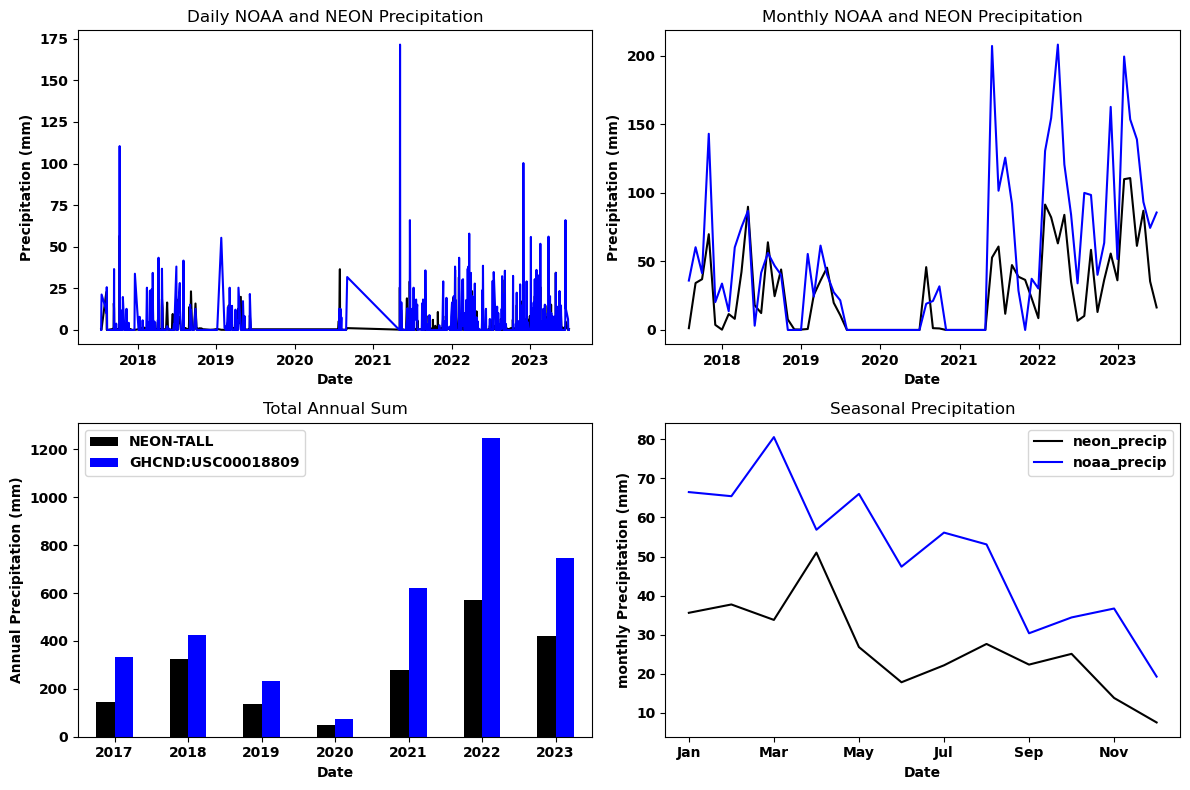

In [11]:
import matplotlib.pyplot as plt
# Resampling data
m_data = data.resample('M').sum()
annual_data = data.resample('Y').sum()
seasonal_data = m_data.groupby(m_data.index.month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonal_data.index = months

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Daily Precipitation
axs[0, 0].plot(data.index, data['neon_precip'], 'k', label='NEON-TALL')
axs[0, 0].plot(data.index, data['noaa_precip'], 'b', label= station_id)
axs[0, 0].set(title='Daily NOAA and NEON Precipitation', xlabel='Date', ylabel='Precipitation (mm)')

# Monthly Precipitation
axs[0, 1].plot(m_data.index, m_data['neon_precip'], 'k', label='NEON-TALL')
axs[0, 1].plot(m_data.index, m_data['noaa_precip'], 'b', label= station_id)
axs[0, 1].set(title='Monthly NOAA and NEON Precipitation', xlabel='Date', ylabel='Precipitation (mm)')

# Annual Precipitation
annual_data.plot(kind='bar', ax=axs[1, 0], color=['black', 'blue'])
axs[1, 0].set(title='Total Annual Sum', xlabel='Date', ylabel='Annual Precipitation (mm)')
axs[1, 0].legend(['NEON-TALL', station_id])
axs[1, 0].set_xticklabels(annual_data.index.year, rotation=0)

# Seasonal Precipitation Variations
seasonal_data.plot(ax=axs[1, 1], color=['black', 'blue'])
axs[1, 1].set(title='Seasonal Precipitation', xlabel='Date', ylabel='monthly Precipitation (mm)')

plt.tight_layout()
plt.show()

##### 6. Summary Statistics

In [24]:
from sklearn.metrics import mean_squared_error

# Summary statistics for both NEON and NOAA stations
summary_stats = data.describe().transpose()

# Evaluation metrics
correlation = data['neon_precip'].corr(data['noaa_precip'])
rmse = np.sqrt(mean_squared_error(data['noaa_precip'], data['neon_precip']))
bias = (data['neon_precip'] - data['noaa_precip']).mean()

# Display the summary statistics
summary_table = summary_stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_table.columns = ['Mean', 'Std Dev', 'Min', '25th', 'Median', '75th', 'Max']

# Add metrics to the summary
additional_metrics = pd.DataFrame({
    'Metric': ['Correlation', 'RMSE', 'Bias'], 'Value': [correlation, rmse, bias]})

# Display the summary statistics
print("Daily Summary Stats for NEON and NOAA Precipitation Datasets:")
print(summary_table)
print("\nEvaluation Metrics:")
print(additional_metrics)

Daily Summary Stats for NEON and NOAA Precipitation Datasets:
                 Mean    Std Dev  Min  25th  Median  75th    Max
neon_precip  2.171622   5.200562  0.0   0.2     0.5   1.0   56.7
noaa_precip  4.139977  11.768334  0.0   0.0     0.0   2.3  171.5

Evaluation Metrics:
        Metric      Value
0  Correlation   0.421312
1         RMSE  10.849670
2         Bias  -1.968356
